In [13]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from util.functions import get_data_ticker, dias_uteis_entre_datas, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import keras
from keras.layers import Input, LSTM, Dense
from keras import Sequential


In [14]:
EMPRESA = 'PETR4.SA'
SEED = 42
qtdTreino = .9

np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

## Obter dados

In [15]:
dados = get_data_ticker(EMPRESA, period='5y')
dados['Close_diff'] = dados['Close'].diff().dropna()
dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Decomposição

### Análises para descobrir o melhor "period"

#### ACF

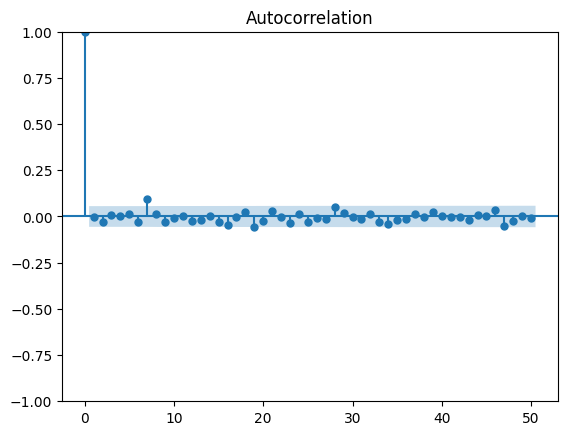

In [16]:
plot_acf(dados['Close_diff'], lags=50) 
plt.show()

### Seasonal decompose

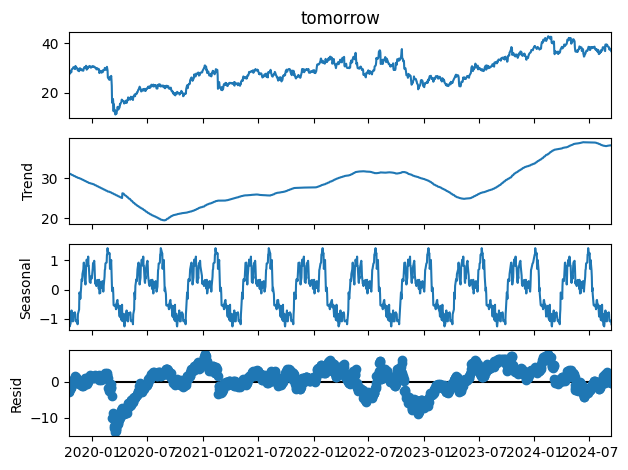

In [17]:
season = decompor_sinal(dados['tomorrow'], period=120 )
tendencia = season.trend

season.plot()
plt.show()

# plt.figure(figsize=(10,3))
# tendencia.plot()

## Pré processamento

In [18]:
tendencia.dropna()
dados.loc[tendencia.dropna().index].copy()
dados['tomorrow'] = tendencia

In [19]:
fig = px.line(dados, y=['Close', 'tomorrow'])
fig.show()

Separando dados de treino e teste

In [20]:
qtdDados = len(dados)
dados_treino = dados[:int(qtdDados * qtdTreino)]
dados_teste = dados[int(qtdDados * qtdTreino):]


# Plotando os dados de treino e teste no mesmo gráfico
dtr_plot = dados_treino.copy()
dte_plot = dados_teste.copy()
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

dados_concat = pd.concat([dtr_plot, dte_plot])
fig = px.line(dados_concat, y=['Close', 'tomorrow'], color='tipo')
fig.show()

In [21]:
X_train, y_train = dados_treino.drop(columns='tomorrow'), dados_treino['tomorrow']
X_test, y_test = dados_teste.drop(columns='tomorrow'), dados_teste['tomorrow']

## Modelos

### Prophet

In [22]:
np.random.seed(42)

df_prophet = pd.DataFrame()
df_prophet['ds'] = dados.index
df_prophet['y'] = dados['Close'].reset_index(drop=True)

tamanho_treino = int(len(df_prophet)*.8)
tamanho_teste = int(len(df_prophet)*.2)

df_treino = df_prophet[:tamanho_treino]
df_teste = df_prophet[tamanho_treino:]

modelo_prophet = Prophet()
modelo_prophet.fit(df_treino)

futuro = modelo_prophet.make_future_dataframe(periods=len(df_teste), freq='D')
previsao = modelo_prophet.predict(futuro)

14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing


MSE: 54.91; RMSE: 7.41


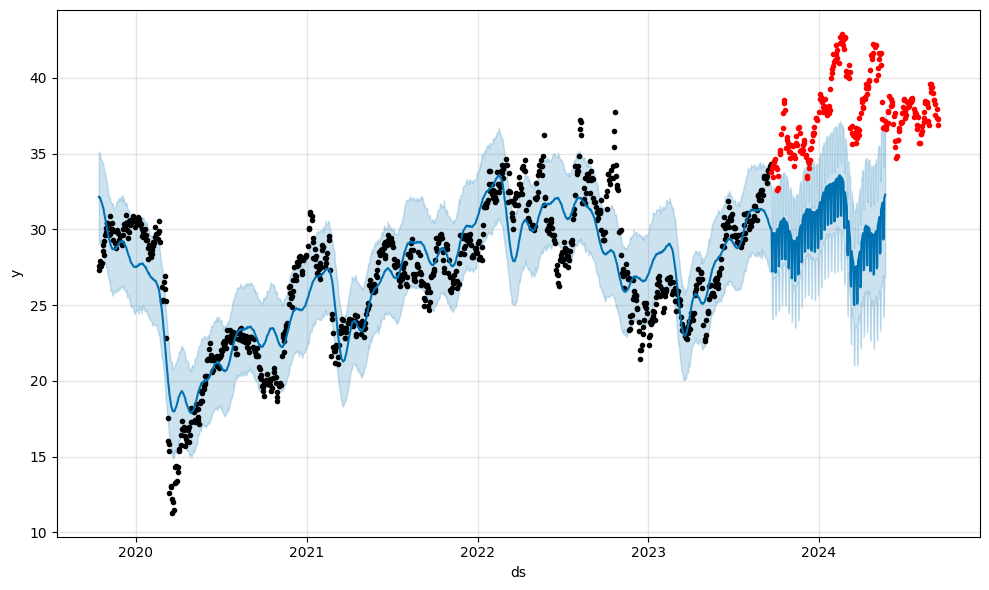

In [23]:
modelo_prophet.plot(previsao)

plt.plot(df_teste['ds'],df_teste['y'],'.r')

from sklearn.metrics import mean_squared_error

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds', how='inner')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}; RMSE: {rmse}')

In [24]:
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)

futuro = modelo_prophet.make_future_dataframe(periods=0, freq='D')
previsao = modelo_prophet.predict(futuro)

df_prophet_sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])]

modelo_prophet.plot()

14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing


TypeError: Prophet.plot() missing 1 required positional argument: 'fcst'

### LSTM

In [44]:
X_train = tf.cast(tf.constant([0.5]),dtype=tf.float32)
y_train = tf.cast(tf.constant([0.6]),dtype=tf.float32)

In [42]:
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(7, 7), name='Input'))
modelo_lstm.add(LSTM(128, name='LSTM'))
modelo_lstm.add(Dense(units=1, name='Output'))

# Pode-se utilizar optimizer adam tbm
modelo_lstm.compile(optimizer='RMSProp', loss='mean_squared_error')

In [27]:
modelo_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 128)            │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,273 (274.50 KB)

 Trainable params: 70,273 (274.50 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:

modelo_lstm.fit(X_train, y_train, epochs=10)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None,), dtype=float32). Expected shape (None, 7, 7), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=True
  • mask=None